In [138]:
ifile = "output.root" #fixed electron gun; 200 events; default position

In [139]:
import ROOT

In [140]:
# import libraries
import uproot3 as uproot
import uproot as uproot4
import numpy as np
#import numba
import awkward as ak

In [141]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm

In [142]:
from sklearn.cluster import KMeans
import random
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.stats import crystalball
from lmfit import Model
import copy
#from coffea import hist

In [143]:
# Process Data
def getData(fname="", procName="Events"):
    kn_dict = uproot.open(fname)["Events"].arrays()
    kn_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in kn_dict.items()}
    kn_events = ak.zip({"Hits":ak.zip({
                                      "detID":   kn_dict_ak1["hit_detID"],
                                      "edep":    kn_dict_ak1["hit_edep"],
                                      "elmID":   kn_dict_ak1["hit_elmID"],
                                      "truthx":  kn_dict_ak1["hit_truthx"],
                                      "truthy":  kn_dict_ak1["hit_truthy"],
                                      "truthz":  kn_dict_ak1["hit_truthz"],
                                      }),
                        "Electrons":ak.zip({
                                            "ge":      kn_dict_ak1["ge"],
                                        }),
                       }, depth_limit=1)
    return kn_events

In [144]:
# Create selections/masks
def emcal_selection(arr):
    mask = (arr.detID == 100)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [145]:
def printemcalhits_byevent(ifile):
    kn_events = getData(ifile,"Events")
    kn_hits = kn_events["Hits"]
    ecal_mask = ak.any(kn_hits.detID == 100, axis=1)
    ecal_index = np.where(ecal_mask)
    print('Fraction of events with hits reaching EMCAL: ',len(ecal_index[0])/len(kn_events))
    print("Let's print the evt numbers we can use to plot EMCAL clusters")
    print('Indices of evts w. EMCAL hits:',ecal_index)

In [146]:
# load data
kn_events = getData(ifile,"Events")

In [147]:
printemcalhits_byevent(ifile)

Fraction of events with hits reaching EMCAL:  0.97
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [0, 1, 2, 3, 4, ... 95, 96, 97, 98, 99] type='97 * int64'>,)


In [148]:
kn_events = getData(ifile,"Events")
kn_hits = kn_events["Hits"]
print(len(kn_hits[0]))
print(kn_hits[0][0]['detID'])
print(kn_hits[0][0])

66
1
... edep: 3.4e+38, elmID: 100, truthx: -0.293, truthy: -1.67, truthz: 595}


In [149]:
print(1018//36)
print(1018%36)

28
10


In [151]:
def emcal_byevent(ifile,evtNum):
    # set up EMCAL
    ntowersx=72
    ntowersy=36
    sizex=5.53 # in cm
    sizey=5.53 # in cm

    ecalx=[-200,200] #size in cm
    ecaly=[-100,100]
    binsx=ecalx[1]-ecalx[0]
    binsy=ecaly[1]-ecaly[0]
    
    kn_hits = kn_events[evtNum]["Hits"]
    kn_electrons = kn_events[evtNum]["Electrons"]
    
    ge = kn_electrons.ge # truth energy
    
    emcal_mask = emcal_selection(kn_hits)
    emcal_hits = kn_hits[emcal_mask]
    emcal_towerx = emcal_hits.elmID//ntowersy
    emcal_towery = emcal_hits.elmID%ntowersy
    emcal_truthx = emcal_hits.truthx
    emcal_truthy = emcal_hits.truthy
    emcal_x = ecalx[0]+emcal_towerx*sizex
    emcal_y = ecaly[0]+emcal_towery*sizey
    emcal_edep = emcal_hits.edep
    
    st3_mask = st3_selection(kn_hits)
    st3_hits = kn_hits[st3_mask]

    st2_mask = st2_selection(kn_hits)
    st2_hits = kn_hits[st2_mask]
    st2_truthx = st2_hits.truthx
    st2_truthy = st2_hits.truthy
    
    h2_mask = h2_selection(kn_hits)
    h2_hits = kn_hits[h2_mask]
    
    print("St3 hits %i, St2 hits %i, H2 hits %i"%(len(st3_hits),len(st2_hits),len(h2_hits)))
    print("Event "+str(evtNum)+": "+str(len(emcal_hits))+" hits")
    
    energy_weights = np.divide(np.array(emcal_edep),np.max(emcal_edep))
    
    # kmeans clustering
    
    # find best number of clusters
    wcss = 0
    wcss_list = []
    for k in range(1,11): # preform kmeans on 1-10 clusters to determine best number
        if k <= len(emcal_hits):
            kmeans = KMeans(n_clusters=k,random_state=0,max_iter=1000)
            X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
            Y = energy_weights
            wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
            predicted_kmeans = kmeans.predict(X, sample_weight = Y)
            centers = wt_kmeansclus.cluster_centers_
            wcss_test = wt_kmeansclus.inertia_
            wcss_list.append(wcss_test)
        if abs(wcss_test-wcss) > 500 or wcss == 0: # if the next number of clusters improved significantly from before
            wcss = wcss_test
            optimal_num_clusters = k
            
    if len(emcal_hits) >= optimal_num_clusters: # if more hits than optimal # clusters proceed normally
        kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=0, max_iter=1000)
    else: # if less hits that optimal # clusters make optimal # clusters = # hits
        print("Defaulting to 'emcal_hits' # of clusters")
        optimal_num_clusters = len(emcal_hits)
        kmeans = KMeans(n_clusters= optimal_num_clusters, random_state=0, max_iter=1000)
        
    X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
    Y = energy_weights
    wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
    predicted_kmeans = kmeans.predict(X, sample_weight = Y)
    
    # energy weighted mean position
    sfc = .1135
    energy_weighted_mean_pos = []
    e_tot_cluster = []
    cells = []
    for i in range(optimal_num_clusters): # for each cluster
        e_weight_x = 0
        e_weight_y = 0
        e_tot = 0
        num_cells = 0
        for j in range(len(predicted_kmeans)): # for each hit
            if predicted_kmeans[j] == i: # check if hit belongs to cluster
                num_cells += 1 # update info
                e_tot += emcal_edep[j]
                e_weight_x += (emcal_edep[j])*X[:,0][j]
                e_weight_y += (emcal_edep[j])*X[:,1][j]
        
        energy_weighted_mean_pos.append([e_weight_x/e_tot,e_weight_y/e_tot])
        e_tot_cluster.append(e_tot)
        cells.append(num_cells)
    
    # energy weighted width calculation
    e_weight_width = []
    e_weight_width_r = []
    for i in range(optimal_num_clusters): # for each cluster
        x_mean = energy_weighted_mean_pos[i][0]
        y_mean = energy_weighted_mean_pos[i][1]
        e_width_x = 0
        e_width_y = 0
        e_width_r = 0
        for j in range(len(predicted_kmeans)): # for each hit
            if predicted_kmeans[j] == i: # if hit corresponds to cluster then update info
                e_width_x += (emcal_edep[j])*(X[:,0][j]-x_mean)**2
                e_width_y += (emcal_edep[j])*(X[:,1][j]-y_mean)**2
                vec_magnitude = ((X[:,0][j]-x_mean)**2 + (X[:,1][j]-y_mean)**2)**(1/2)
                e_width_r += (emcal_edep[j])*((vec_magnitude)**2)

        e_weight_width.append([(e_width_x/e_tot_cluster[i])**(1/2),(e_width_y/e_tot_cluster[i])**(1/2)])
        e_weight_width_r.append((e_width_r/e_tot_cluster[i])**(1/2))
    
    # truth energy
    particle_energy = ge[0]
    
    return (optimal_num_clusters,e_weight_width,e_weight_width_r,e_tot_cluster,particle_energy, energy_weighted_mean_pos)

In [154]:
# run analysis
kn_hits = kn_events["Hits"]
ecal_mask = ak.any(kn_hits.detID == 100, axis=1)
ecal_index = np.where(ecal_mask)
events = ecal_index[0]

cluster_energies = []
cluster_energies_perEvent = []
particle_energy = []
event_energy = []
energy_residual = []
energy_resolution = []
number_clusters = []
cluster_positions = []

for i in events:
    print('Event #'+str(i))
    event_data = emcal_byevent(ifile,i)
    num_clusters = event_data[0]
    truth_energy = event_data[4]
    particle_energy.append(truth_energy)
    number_clusters.append(num_clusters)
    cluster_positions.append(event_data[5])
    
    reco_hits_energy = 0
    clus_pE = []
    for j in range(num_clusters):
        cluster_energy = event_data[3][j]
        clus_pE.append(cluster_energy)
        cluster_energies.append(cluster_energy)
        reco_hits_energy += cluster_energy
    cluster_energies_perEvent.append(clus_pE)
    event_energy.append(reco_hits_energy)
    energy_residual.append(reco_hits_energy - truth_energy)
    energy_resolution.append((reco_hits_energy - truth_energy)/(truth_energy))

Event #0
St3 hits 6, St2 hits 6, H2 hits 3
Event 0: 42 hits
Event #1
St3 hits 12, St2 hits 6, H2 hits 2
Event 1: 53 hits
Event #2
St3 hits 6, St2 hits 6, H2 hits 2
Event 2: 44 hits
Event #3
St3 hits 6, St2 hits 6, H2 hits 2
Event 3: 49 hits
Event #4
St3 hits 6, St2 hits 6, H2 hits 2
Event 4: 22 hits
Event #5
St3 hits 12, St2 hits 6, H2 hits 2
Event 5: 54 hits
Event #6
St3 hits 6, St2 hits 6, H2 hits 2
Event 6: 54 hits
Event #7
St3 hits 12, St2 hits 6, H2 hits 2
Event 7: 49 hits
Event #8
St3 hits 6, St2 hits 6, H2 hits 2
Event 8: 37 hits
Event #9
St3 hits 6, St2 hits 6, H2 hits 2
Event 9: 35 hits
Event #10
St3 hits 6, St2 hits 6, H2 hits 2
Event 10: 50 hits
Event #11
St3 hits 6, St2 hits 6, H2 hits 2
Event 11: 29 hits
Event #12
St3 hits 6, St2 hits 6, H2 hits 2
Event 12: 40 hits
Event #13
St3 hits 6, St2 hits 6, H2 hits 2
Event 13: 45 hits
Event #14
St3 hits 6, St2 hits 6, H2 hits 2
Event 14: 32 hits
Event #15
St3 hits 6, St2 hits 6, H2 hits 2
Event 15: 41 hits
Event #16
St3 hits 6, St2

In [89]:
particle_energy_arraySAVE = np.array(particle_energy)
event_energy_arraySAVE = np.array(event_energy)
truth_energySAVE = np.array(particle_energy)
reco_energySAVE = np.array(event_energy)
cluster_energy_arraySAVE = np.array(cluster_energies)
cluster_positions_arraySAVE = np.array(cluster_positions)
np.savez('Saved_200_electron_Ecal_info.npz', particle_energy=particle_energy_arraySAVE, event_energy=event_energy_arraySAVE)

<ipython-input-89-7e63894e0b17>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_positions_arraySAVE = np.array(cluster_positions)


In [90]:
loadfi = np.load('Saved_200_electron_Ecal_info.npz')
for i in loadfi.keys():
    print(i)

particle_energy
event_energy


In [153]:
particle_energy = loadfi['particle_energy']
event_energy = loadfi['event_energy']

In [122]:
print(len(event_energy))
print(ecal_index[0])
print(particle_energy[0:10])
print(event_energy[0:10])

184
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[43.41241837 13.09499454 46.05493164 49.0813446  31.11095428 32.53380585
 74.82797241  6.55713844  7.17892742  8.03418827]
[4.74697074 0.94025083 4.16595917 5.4196562  3.36467973 3.10250752
 8.49455325 0.61892935 0.25702219 0.64162027]


In [123]:
test = emcal_byevent(ifile,0)

St3 hits 6, St2 hits 6, H2 hits 2
Event 0: 121 hits


In [124]:
print(test)

(6, [[4.649732374157167, 5.02293558533253], [2.6210248696150162, 2.4852766944017852], [2.7905359790604822, 2.754085716381378], [3.845627616781391, 5.455524760914252], [8.494971873647936, 15.266498677808771], [10.199608909860192, 8.412986735310517]], [6.844698170532072, 3.611976137085775, 3.920724318746088, 6.674698658658699, 17.470847976375, 13.221587186212178], [1.0814656628499506, 0.24269742175238207, 3.7895564222926623, 0.508452309994027, 0.009053862071596086, 0.07275966167799197], 55.96424102783203, [[102.52369251937579, -22.07721435716812], [-185.03428754926702, -21.374206718283652], [-12.84495868637678, -16.559038603862813], [-94.5024992209064, -11.614281885117002], [31.576240071324843, -84.06828524420517], [25.217233353492485, -5.790827197427543]])


[3.76e-05, 0.00059, 0.000496, 0.000649, ... 0.000116, 0.000466, 0.000866, 8e-05]


Warning in <TROOT::Append>: Replacing existing TH1: a (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 3d


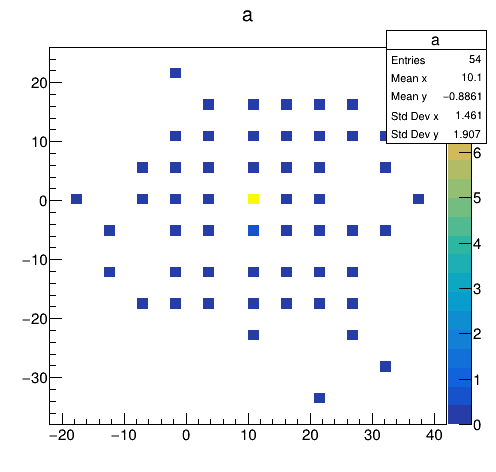

In [179]:
test2d = ROOT.TH2F('a','a',36,-200,200,36,100,100)

kn_hits = kn_events[5]["Hits"]
kn_electrons = kn_events[5]["Electrons"]
ge = kn_electrons.ge

emcal_mask = emcal_selection(kn_hits)
emcal_hits = kn_hits[emcal_mask]
emcal_towerx = emcal_hits.elmID//36
emcal_towery = emcal_hits.elmID%36
emcal_truthx = emcal_hits.truthx
emcal_truthy = emcal_hits.truthy
emcal_x = -200+emcal_towerx*5.53
emcal_y = -100+emcal_towery*5.53
emcal_edep = emcal_hits.edep

print(emcal_edep)
for i in range(0,len(emcal_edep)):
    test2d.Fill(emcal_x[i], emcal_y[i], emcal_edep[i])

can2d = ROOT.TCanvas('3d','3d', 500, 500)
test2d.Draw('colz')
test2d.GetXaxis().SetRangeUser(-200,200)
test2d.GetYaxis().SetRangeUser(-100,100)
can2d.Draw()

In [ ]:
"""
# energy resolution data
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy)
cluster_energy_array = np.array(cluster_energies)

def resolqt(y):
    return(np.percentile(y,84)-np.percentile(y,50))

#binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.array([25, 35, 50, 70, 100])))
binnings = np.linspace(0,100,num=11)
   
bin_avg,bin_edges,binnumber = binned_statistic(truth_energy,truth_energy, statistic='mean', bins=binnings, range=(0,100))
print("bin avg: ",bin_avg)
bin_means,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy, statistic='mean', bins=binnings, range=(0,100))
responses,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy/truth_energy, statistic='mean', bins=binnings, range=(0,100))
sfs = np.take(responses, np.digitize(truth_energy, binnings)-1, mode='clip')
print("scale factors ", sfs)
bin_resols,bin_edges,binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic='std', bins=binnings, range=(0,100))
bin_resol_qts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic=resolqt, bins=binnings, range=(0,100))
bin_counts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy, statistic='count', bins=binnings, range=(0,100))
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]

maxbin = np.digitize(np.array([40.0]), binnings)[0]
minbin = 1

def func(x, a,b):
    return np.sqrt(a**2 + b**2/x)

def func1(x, a, mu, sigmaL,sigmaR):
    arg = x - mu
    coef = np.copy(x)
    coef[arg>0] = -0.5/(sigmaR*sigmaR)
    coef[arg<0] = -0.5/(sigmaL*sigmaL)
    #if arg > 0:
    #    coef = -0.5/(sigmaL*sigmaL);
    #else:
    #    coef = -0.5/(sigmaR*sigmaR);
    return a * np.exp(coef*arg*arg);
        
def fitdata(data, postfix="", makePlot=True):
    n, bin_edges = np.histogram(data, bins=50, density=True)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
    popt, pcov = curve_fit(func1, bincenters, n)#, bounds=(0, [10, 1.0,10.0, 10.0]))
    #print(popt)
        
        #if makePlot:
         #   fig = plt.figure(figsize=(10,8))
          #  plt.plot([],[], 'none', label="Truth Energy: "+ postfix + " GeV")
           # plt.bar(bincenters, n, align='center', width=bin_edges[1]-bin_edges[0])
            #plt.plot(bincenters, func1(bincenters, *popt), 'r-', label='Fit Result')
            #plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
            #plt.plot([],[], 'none', label=r'$\sigma_{L}=%.4f$'%popt[2])
            #plt.plot([],[], 'none', label=r'$\sigma_{R}=%.4f$'%popt[3])
            #plt.legend(loc="upper left", bbox_to_anchor=(0.02,0.95))
            #plt.show()
            #plt.xlim(-1,1)
            #plt.xlabel("TruthEnergy - ClustereEnergy [GeV]")
            #plt.ylabel('A.U.')
            #plt.savefig("electron_energy_diff" + postfix + ".png")
    return popt[2], popt[3]
    
sigmaLs = []
sigmaRs = []
for ibin in range(binnings.shape[0]-1):
    print("binning: ", binnings[ibin], binnings[ibin+1])
    data_in_one_bin = (1/sfs*reco_energy - truth_energy)[np.where(np.digitize(truth_energy, binnings)==ibin+1)]
    #print("data in one bin: ", data_in_one_bin)
    sigmaL, sigmaR = fitdata(data_in_one_bin, str(binnings[ibin])+"-"+str(binnings[ibin+1]))
    sigmaLs.append(sigmaL)
    sigmaRs.append(sigmaR)
        
sigmaLs = np.array(sigmaLs)
sigmaRs = np.array(sigmaRs)
    
print("bin_means", bin_means.shape[0])
print("sigmaLs", sigmaLs.shape[0])
print("sigmaRs", sigmaRs.shape[0])

## average of (sigmaL + sigmaR)
popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], ((sigmaLs+sigmaRs)/2.0*responses/bin_means)[minbin:maxbin])#, bounds=(0, [0.03, 0.1]))
plt.figure(figsize=(8,6))
plt.hlines((sigmaLs+sigmaRs)/2.0*responses/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
#plt.xlim(1.0,70.0)
#plt.ylim(0,0.12)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
#plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')
#plt.xscale('log')
plt.plot(bin_centers[minbin:maxbin], func(bin_centers[minbin:maxbin], *popt), 'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
plt.legend()
"""

In [ ]:
"""
# energy resolution data
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy) * .1135
cluster_energy_array = np.array(cluster_energies)

def resolqt(y):
    return(np.percentile(y,84)-np.percentile(y,50))

#binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.array([25, 35, 50, 70, 100])))
binnings = np.linspace(0,100,num=11)
   
bin_avg,bin_edges,binnumber = binned_statistic(truth_energy,truth_energy, statistic='mean', bins=binnings, range=(0,100))
print("bin avg: ",bin_avg)
bin_means,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy, statistic='mean', bins=binnings, range=(0,100))
responses,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy/truth_energy, statistic='mean', bins=binnings, range=(0,100))
sfs = np.take(responses, np.digitize(truth_energy, binnings)-1, mode='clip')
print("scale factors ", sfs)
bin_resols,bin_edges,binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic='std', bins=binnings, range=(0,100))
bin_resol_qts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic=resolqt, bins=binnings, range=(0,100))
bin_counts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy, statistic='count', bins=binnings, range=(0,100))
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]

maxbin = np.digitize(np.array([40.0]), binnings)[0]
minbin = 1

def func(x, a,b):
    return np.sqrt(a**2 + b**2/x)

def func1(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
def fitdata(data, postfix=""):
    n, bin_edges = np.histogram(data, bins=50, density=True)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
    popt, pcov = curve_fit(func1, xdata = bincenters, ydata = n,sigma = np.sqrt(n),absolute_sigma = False)
    return popt[1], popt[2]
    
sigmas = []
means = []
for ibin in range(binnings.shape[0]-1):
    print("binning: ", binnings[ibin], binnings[ibin+1])
    data_in_one_bin = (((1/sfs)*reco_energy) - truth_energy)[np.where(np.digitize(truth_energy, binnings)==ibin+1)]
    #print(len(data_in_one_bin))
    print("data in one bin: ", data_in_one_bin)
    
    plt.figure()
    plt.hist(data_in_one_bin,
                bins = 50,
                range = [-25,25],
                density = True)
    
    mean_fit, std_fit = fitdata(data_in_one_bin, str(binnings[ibin])+"-"+str(binnings[ibin+1]))
    sigmas.append(std_fit)
    means.append(mean_fit)
        
sigmas = np.array(sigmas)
means = np.array(means)
    
print("bin_means", bin_means.shape[0])
print("sigmaLs", sigmaLs.shape[0])
print("sigmaRs", sigmaRs.shape[0])
print(sigmas)

## average of (sigmaL + sigmaR)
popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], ((sigmas*responses/bin_means))[minbin:maxbin])
plt.figure(figsize=(8,6))
plt.hlines((sigmas*responses)/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
#plt.xlim(1.0,70.0)
plt.ylim(0,0.12)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
#plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')
#plt.xscale('log')
plt.plot(bin_centers[minbin:maxbin], func(bin_centers, *popt)[minbin:maxbin],'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
plt.legend()
print(popt)
"""

In [ ]:
"""
# manual binning
truth_energy_10 = []
truth_energy_20 = []
truth_energy_30 = []
truth_energy_40 = []
truth_energy_50 = []
truth_energy_60 = []
truth_energy_70 = []
truth_energy_80 = []
truth_energy_90 = []
truth_energy_100 = []

energy_10 = []
energy_20 = []
energy_30 = []
energy_40 = []
energy_50 = []
energy_60 = []
energy_70 = []
energy_80 = []
energy_90 = []
energy_100 = []

for i in range(len(particle_energy)):
    if 0 <= particle_energy[i] < 10:
        truth_energy_10.append(particle_energy[i])
        energy_10.append(energy_residual[i])
    elif 10<= particle_energy[i] < 20:
        truth_energy_20.append(particle_energy[i])
        energy_20.append(energy_residual[i])
    elif 20 <= particle_energy[i] < 30:
        truth_energy_30.append(particle_energy[i])
        energy_30.append(energy_residual[i])
    elif 30<= particle_energy[i] < 40:
        truth_energy_40.append(particle_energy[i])
        energy_40.append(energy_residual[i])
    elif 40 <= particle_energy[i] < 50:
        truth_energy_50.append(particle_energy[i])
        energy_50.append(energy_residual[i])
    elif 50<= particle_energy[i] < 60:
        truth_energy_60.append(particle_energy[i])
        energy_60.append(energy_residual[i])
    elif 60 <= particle_energy[i] < 70:
        truth_energy_70.append(particle_energy[i])
        energy_70.append(energy_residual[i])
    elif 70<= particle_energy[i] < 80:
        truth_energy_80.append(particle_energy[i])
        energy_80.append(energy_residual[i])
    elif 80 <= particle_energy[i] < 90:
        truth_energy_90.append(particle_energy[i])
        energy_90.append(energy_residual[i])
    elif 90 <= particle_energy[i] < 100:
        truth_energy_100.append(particle_energy[i])
        energy_100.append(energy_residual[i])
"""

0.11124447366540391
0.07422850192127557


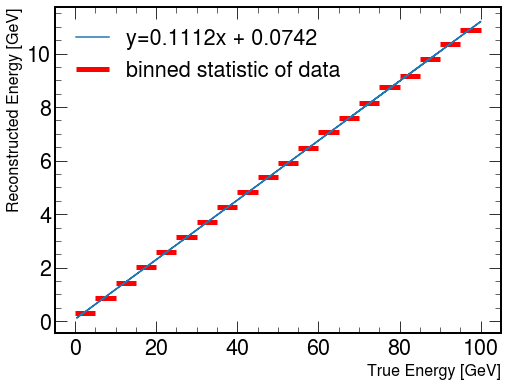

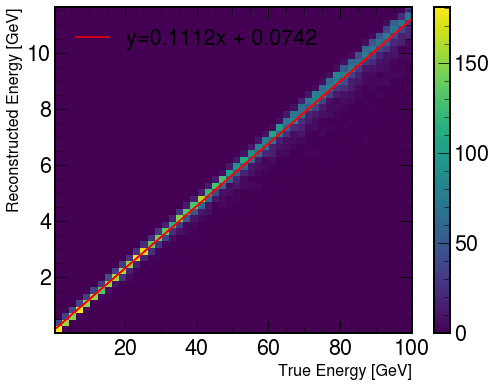

In [13]:
# calculate sfc
#binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.array([25, 35, 50, 70, 100])))
binnings = np.linspace(0,100,21)
bin_avg,    bin_edges, binnumber = binned_statistic(particle_energy, event_energy, statistic='mean', bins=binnings, range=(0,100))
bincenters = np.array([0.5 * (binnings[i] + binnings[i+1]) for i in range(len(binnings)-1)])

plt.figure(figsize=(8,6))
plt.hlines(bin_avg, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
#plt.scatter(particle_energy,event_energy,c='red')
plt.xlabel('True Energy [GeV]',size=16)
plt.ylabel('Reconstructed Energy [GeV]',size=16)

particle_energy_array = np.array(particle_energy)
event_energy_array = np.array(event_energy)
m,b = np.polyfit(particle_energy_array,event_energy_array,1)
#m,b = np.polyfit(bincenters,bin_avg,1)
plt.plot(particle_energy_array, m*particle_energy_array + b,label='y={:.4f}x + {:.4f}'.format(m,b))
plt.legend()
print(m)
print(b)
sfc = m
plt.savefig('Sampling Fraction Correction Plot',facecolor='white',edgecolor='white',bbox_inches='tight')

plt.figure(figsize=(8,6))
plt.hist2d(particle_energy,event_energy,bins=50)
plt.colorbar()
plt.ylabel('Reconstructed Energy [GeV]',size=16)
plt.xlabel('True Energy [GeV]',size=16)

plt.plot(particle_energy_array, m*particle_energy_array + b,label='y={:.4f}x + {:.4f}'.format(m,b),c='red')
plt.legend()
plt.savefig('Photon: True vs Reco Energy',facecolor='white',edgecolor='white',bbox_inches='tight')

In [14]:
# energy resolution data
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy)
cluster_energy_array = np.array(cluster_energies)

energy=[energy_10,energy_20,energy_30,energy_40,energy_50,energy_60,energy_70,energy_80,energy_90,energy_100]

def func(x, a,b,c): # resolution function
    return np.sqrt((a**2) + (b**2)/x + (c**2)/np.sqrt(x))

def func1(x, A, mu, sig): # gaussian function
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
def fitdata(data): # fits data to gaussian function to get mean and std
    n, bin_edges = np.histogram(data, bins=50, density=True)
    mask = n!=0
    bincenters = np.asarray([(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)])
    plt.hist(data,
            bins = 50,
            range = [-50,50],
            density = True)
    plt.show()
    popt, pcov = curve_fit(func1, xdata = bincenters[mask], ydata = n[mask], sigma=np.sqrt(n[mask]),absolute_sigma=False,p0=[1,0,.5])
    return popt[1], popt[2]

sigmas = []
means = []
for energy_list in energy: # energy = list of lists, each list has reco-truth energy values for a given bin
    #print(energy_list)
    mean_fit, std_fit = fitdata(np.asarray(energy_list)) # call fitdata to get mean and sigma
    print(std_fit,mean_fit)
    sigmas.append(std_fit)
    means.append(mean_fit)

sigmas = np.array(sigmas)
means = np.array(means)

print(sigmas) # check that it worked :(

NameError: name 'cluster_energies' is not defined

In [15]:
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy) / sfc
cluster_energy_array = np.array(cluster_energies)

#print(event_energy)
print(reco_energy)
print(truth_energy)

def func(x, a,b,c): # resolution function
    return np.sqrt((a**2) + (b**2)/x + (c**2)/np.sqrt(x))

e_resolution = [] #To save the resolution (sigma) of the fit
e_average = []
e_ranges = []
e_err = []
    
#Specify the ranges to calculate the resolution in 
for i in [2,3,4,5,6,7,8,9]:
        
    hist_range = [-20,20]
        
    e_range = 10
    e_min = i*e_range #GeV
    e_max = (i+1)*e_range
    e_ranges.append([e_min,e_max]) #Save for resolution later
        
    print("Truth momentum range: {},{} GeV".format(e_min, e_max))
        
    local_selection = (truth_energy >= e_min) & (truth_energy < e_max)
    e_average.append(np.mean(truth_energy[local_selection]))
        
    e_residual = copy.deepcopy(reco_energy[local_selection] - truth_energy[local_selection])
    print(len(reco_energy[local_selection]),len(truth_energy[local_selection]))
    
    #hist_range=[min(e_residual)-2,max(e_residual)+2]
        
    if e_residual.size != 0:
        
        #Initial distribution and labelling
        plt.hist(e_residual,
                bins = 50,
                range = hist_range,
                density = True)
        plt.plot([],[], 'none', label="Truth Energy: {}-{} GeV".format(e_min, e_max))

        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
        def logistic(x, mu, sig):
            return (np.exp(-(x-mu)/sig)) / (sig*np.power((1+np.exp(-(x-mu)/sig)),2.))
        
        def cauchy(x,mu,sig):
            return (1) / (np.pi*sig*(1+np.power((x-mu)/sig,2)))
        
        def crystal_ball(x, A, B, mu, sig, N,a):
            y = np.piecewise(x,
                            [(x-mu)/sig > a, (x-mu)/sig <= a],
                            [lambda x: N*np.exp(-np.power(x-mu,2.) / (2*np.power(sig,2.))) ,
                             lambda x: N*A*np.power(B-((x-mu)/sig),-2)])
            return y

        bins = np.linspace(hist_range[0], hist_range[1], 51)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(e_residual, bins=bins,
                                           range = hist_range, density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        #popt, pcov = curve_fit(fit_function,
                                #xdata=binscenters[mask],
                                #ydata=data_entries[mask],
                                #sigma = np.sqrt(data_entries[mask]),
                                #absolute_sigma = False,
                                #p0=[1, 0, 0.5])

        popt, pcov = curve_fit(crystal_ball,
                                xdata=binscenters[mask],
                                ydata=data_entries[mask],
                                sigma = np.sqrt(data_entries[mask]),
                                absolute_sigma = False,
                                p0=[.15, 0.0, 0.0, 0.5,1.,2.],
                                maxfev=40000)

        #Error for parameter estimations
        err = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", err)
        #e_err.append(err[2])
        e_err.append(err[3])

        #std_fit = np.abs(popt[2])
        std_fit = np.abs(popt[3])
        #mean_fit = popt[1]
        mean_fit = popt[2]
        res_fit = std_fit/mean_fit
        #sigma_res = err[2]/mean_fit
        sigma_res = err[3]/mean_fit
        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)
        print("Resolution (fit) is {}".format(res_fit))
        e_resolution.append(std_fit)

        #Plot fitted gaussian
        #plt.plot(bins,
                #fit_function(bins, *popt),
                #"r-",
                #linewidth=4,
                #label='Best fit')
        
        print(popt)
        plt.plot(bins,
                crystal_ball(bins, *popt),
                "r-",
                linewidth=4,
                label='Best fit')

        #plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
        #plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[2])
        
        plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[2])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[3])

        #Label the axes
        plt.xlabel(r'Reco $E$ - Truth $E$ (GeV)')
        plt.ylabel('Normalized counts')

        plt.legend()
        fig = plt.gcf()
        plt.show()
        #fig.savefig('{}-{} GeV'.format(e_min,e_max),facecolor='white',edgecolor='white',bbox_inches='tight')

#MAIN PLOT
#Plot momentum average
#plt.scatter(p_average, p_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
#Plot the resolution based on energy range.
plt.scatter(e_average,
            [x/y*100 for x, y in zip(e_resolution, e_average)],
            s = 180,
            label='Mean Energy [GeV]',
            c='green')

#Plot the error bars
plt.errorbar(e_average,
            [x/y*100 for x, y in zip(e_resolution, e_average)],
            yerr=[x/y*100 for x, y in zip(e_err, e_average)],
            fmt='none',
            elinewidth=3,
            capsize=8)

#Plot the bins
plt.hlines([x/y*100 for x, y in zip(e_resolution, e_average)],
            [e_range[0] for e_range in e_ranges],
            [e_range[1] for e_range in e_ranges],
            colors='red')

#Plot resolution function
popt, pcov = curve_fit(func,
                        xdata=e_average,
                        ydata=[x/y*100 for x, y in zip(e_resolution, e_average)],
                        )
plt.plot(e_average,func(e_average,*popt),
        #label='{:.3f}+$\frac{{:.3f}}{<E>} + \frac{{:.3f}}{\sqrt{<E>}}$'.format(*popt)
        )

#Label axes
plt.xlabel(r'Truth $E$ [GeV]')
plt.ylabel(r'$\sigma_{\Delta~E}/E$ [%]')
    
plt.legend()
fig = plt.gcf()
plt.show()

#fig.savefig('Photon 1910cm: Energy Resolution',facecolor='white',edgecolor='white',bbox_inches='tight')


NameError: name 'cluster_energies' is not defined

In [ ]:
# try using lmfit instead
def crystal_ball(x, A, B, mu, sig, N):
            y = np.piecewise(x,
                            [(x-mu)/sig > 2, (x-mu)/sig <= 2],
                            [lambda x: N*np.exp(-np.power(x-mu,2.) / (2*np.power(sig,2.))) ,
                             lambda x: N*A*np.power(B-((x-mu)/sig),-2)])
            return y
cbmodel = Model(crystal_ball)
result = cbmodel.fit(data_entries,
                    x=binscenters,
                    A = .15,
                    B = 0.0,
                    mu= 0.0,
                    sig = 0.5,
                    N = 1)

print(result.fit_report())
plt.figure()
plt.hist(e_residual,
        bins = 50,
        range = hist_range,
        density = True)
plt.plot(binscenters, result.best_fit)

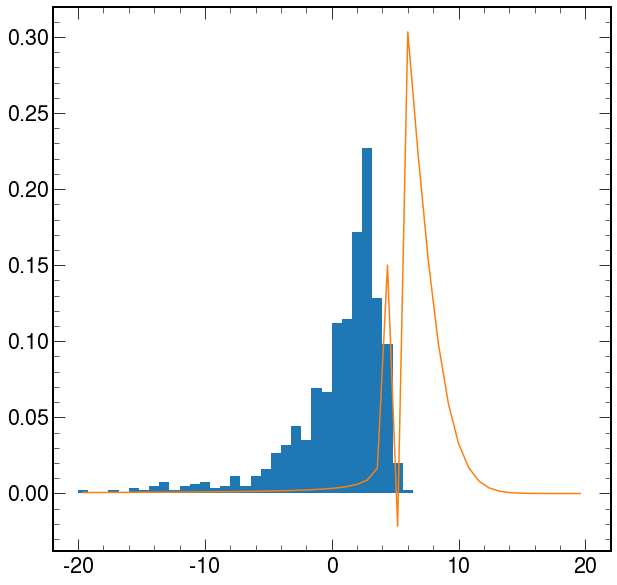

In [32]:
# test if initial values are a good guess
def crystal_ball(x, A, B, mu, sig, N):
        y = np.piecewise(x,
                        [(x-mu)/sig > 1, (x-mu)/sig <= 1],
                        [lambda x: N*np.exp(-np.power(x-mu,2.) / (2*np.power(sig,2.))) ,
                        lambda x: N*A*np.power(B-((x-mu)/sig),-1)])
        return y

plt.figure()
plt.hist(e_residual,
        bins = 50,
        range = hist_range,
        density = True)
plt.plot(binscenters, crystal_ball(binscenters,.01,.5,3,3,.5))

999


(array([0.0025227 , 0.        , 0.00126135, 0.0025227 , 0.00126135,
        0.00378406, 0.0025227 , 0.00504541, 0.00756811, 0.0025227 ,
        0.00504541, 0.00630676, 0.00756811, 0.00378406, 0.00504541,
        0.01135217, 0.00504541, 0.01135217, 0.01639758, 0.0264884 ,
        0.0315338 , 0.04414733, 0.03531786, 0.06937437, 0.06685166,
        0.11226034, 0.11478305, 0.1715439 , 0.22704339, 0.12865792,
        0.09838547, 0.02018163, 0.0025227 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([-20. , -19.2, -18.4, -17.6, -16.8, -16. , -15.2, -14.4, -13.6,
        -12.8, -12. , -11.2, -10.4,  -9.6,  -8.8,  -8. ,  -7.2,  -6.4,
         -5.6,  -4.8,  -4. ,  -3.2,  -2.4,  -1.6,  -0.8,   0. ,   0.8,
          1.6,   2.4,   3.2,   4. ,   4.8,   5.6,   6.4,   7.2,   8. ,
          8.8,   9.6,  10.4,  11.2

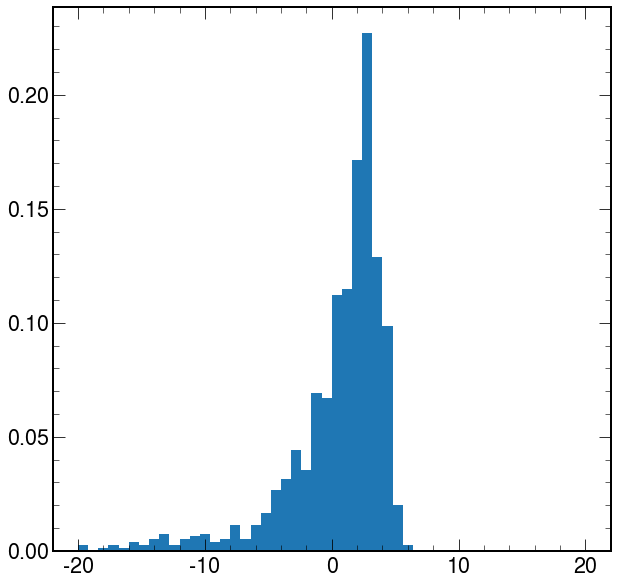

In [47]:
plt.figure()
print(np.size(e_residual))
plt.hist(e_residual,
        bins = 50,
        range = hist_range,
        density = True)

In [98]:
test_hist = ROOT.TH1F('res1','',50,-20,20)
for eres in e_residual:
    test_hist.Fill(eres)

Warning in <TROOT::Append>: Replacing existing TH1: res1 (Potential memory leak).


In [99]:
#crfun = ROOT.TF1('fitFunction', ROOT.Math.crystalball_function(1,2,1,1,0), -20, 20)
f1 = ROOT.TF1('fitFunction', "crystalball", -20, 20)
#f1 = ROOT.TF1('fitFunction', "ROOT::Math::crystalball_function(x, 2, 1, 1, 1)", -20, 20)
f1.SetParameters(100, 1, 1, 1, 1);
#crfun = ROOT.Math.crystalball_function(x[0], par[0], par[1], par[2], par[3])

In [100]:
test_hist.Fit(f1, 'S')

 FCN=38.7549 FROM MIGRAD    STATUS=CONVERGED     307 CALLS         308 TOTAL
                     EDM=8.00531e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.64694e+02   7.93793e+00   6.56469e-03   1.50950e-05
   2  Mean         2.69179e+00   1.01999e-01  -4.31987e-05   1.57529e-03
   3  Sigma        1.17373e+00   6.36435e-02   1.81008e-07   1.55145e-03
   4  Alpha        4.81102e-01   6.30670e-02   9.59095e-06  -1.84905e-03
   5  N            5.53569e+00   1.96493e+00   5.52367e-04  -3.53332e-05


Warning in <TCanvas::Constructor>: Deleting canvas with same name: a


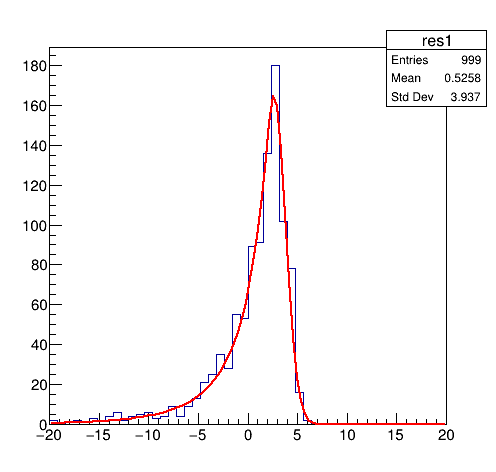

In [101]:
can1 = ROOT.TCanvas('a','a', 500, 500)
test_hist.Draw()
f1.Draw('same')
can1.Draw()